In [121]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

import gc_turbulence as g

%matplotlib inline

In [2]:
index = 'r14_01_14a'
cache_path = g.default_processed + index + '.hdf5'
r = g.ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

Below is the mean of the data in the front relative frame. At this point the data looks as we might expect.

<matplotlib.colorbar.Colorbar instance at 0x2ad740a58fc8>

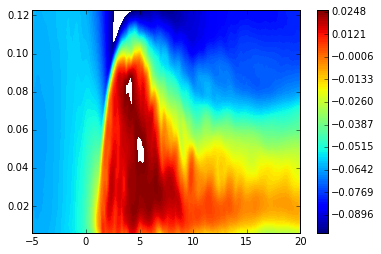

In [3]:
mean = np.mean(r.Uf[...], axis=1)
plt.contourf(tf, zf, mean, levels=u_levels)
plt.colorbar()

However if we consider a single data slice in the front relative frame we can see what appear to be background waves.

<matplotlib.colorbar.Colorbar instance at 0x2ad797356c68>

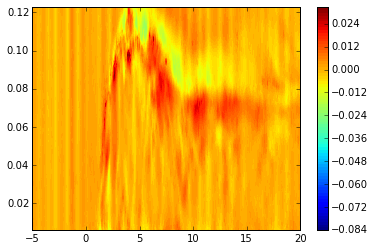

In [191]:
mean_subtracted = r.Uf[...] - mean[..., None, ...]
c = plt.contourf(tf, zf, mean_subtracted[:, 30, :], 100)
plt.colorbar()

We don't see these waves in the front relative mean because they average out over the width of the observation window.

Here is a plot in the lab frame, from a single height.

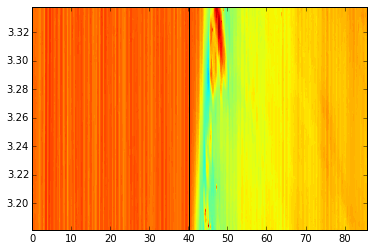

In [212]:
mean_u = np.mean(r.U[-10:, :, :], axis=0)
Te = r.T[0, :, :]
plt.contourf(Te, r.X[0], mean_u, levels=u_levels)

x = r.X[0, :, 0]
plt.plot((0.14 / x) + 40, x, 'k')

We can see that the waves are very fast, compared to the front speed. Importantly, these waves don't appear to be causally related to the current.

A possible source of the waves is residual motion from filling the tank, but we will look at this more later.

We will treat them as background noise that needs to be removed. Leaving these waves in the data will cloud any frequency analysis that we wish to do.

Let's consider a timeseries from a single point in $(x, z)$.

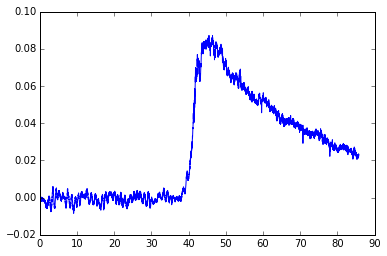

In [6]:
signal = r.U[10, 10, :]
plt.plot(r.T[10, 10, :], signal)

Now let's look at the portion before the front onset:

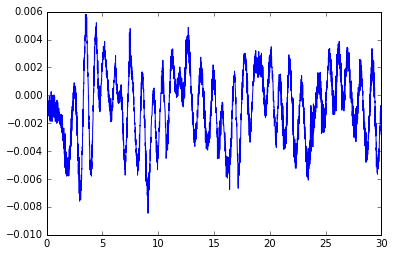

In [9]:
presignal = r.U[10, 10, :3000]
plt.plot(r.T[10, 10, :3000], presignal)

It appears that there are several wave frequencies represented here, as revealed by the frequency power spectrum:

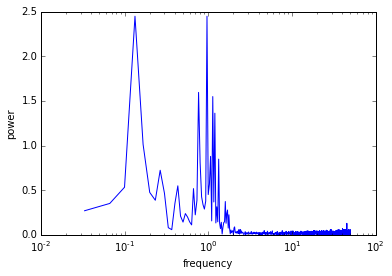

In [10]:
fft = np.fft.rfft(pre_signal)
freqs = np.fft.rfftfreq(presignal.size, d=0.01)
plt.semilogx(freqs, np.abs(fft))
plt.xlabel('frequency')
plt.ylabel('power')

There apears to be a harmonic series beginning at ~0.1Hz, along with a cluster of frequencies about 1Hz.

The cluster of frequencies is interesting. We can look at the wavelet transform to investigate this further.

In [11]:
import wavelets

wt = wavelets.WaveletTransform(presignal, dt=0.01)

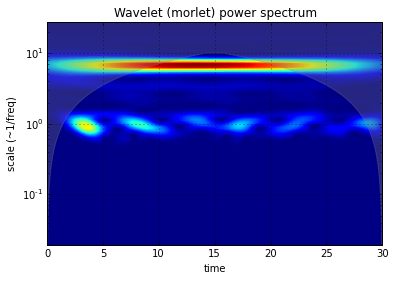

In [13]:
wt.plot_power()
plt.xlabel('time')
plt.ylabel('scale (~1/freq)')
plt.title('Wavelet (morlet) power spectrum')

The harmonic series has frequencies that are represented all through the timeseries, but the cluster is more complicated and has time dependent form.

**In particular, we cannot hope to recover the full wave signal simply by summing the peaks of the fourier transform.**

One feature of the waves is that they are symmetric across all x, z (or near enough, given how fast they are). This is not a property that is shared by the current.

If we can find a way to extract these symmetric features then we might be able to recover the wave signal.

A first guess would be to take the mean across x, z and hope that all other features cancel out leaving the wave signal.

This doesn't work. The data is dominated by the front:

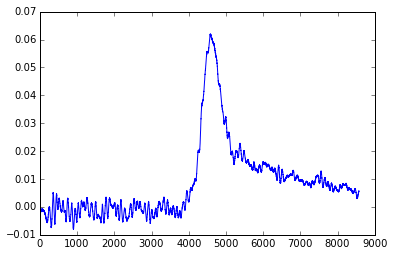

In [16]:
mean_signal = r.U[:].mean(axis=0).mean(axis=0)
plt.plot(mean_signal)

Applying a high pass filter in time may filter this out though. Let's filter out frequencies below 0.7Hz. It is somewhere lower than this that frequencies have wavelengths on the order of the observation window size, i.e. will likely not be averaged out.

<matplotlib.contour.QuadContourSet instance at 0x2ad75804ecf8>

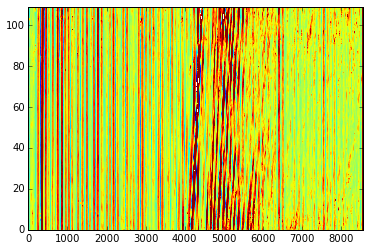

In [21]:
all_x_fft = np.fft.rfft(r.U[40, :, :], axis=-1)
all_freq = np.fft.rfftfreq(r.U.shape[-1], d=0.01)
power = np.abs(all_x_fft)

rfft = all_x_fft.copy()
rfft[:, all_freq < 0.7] = 0  
rdata = np.fft.irfft(rfft, axis=-1)

levels = np.linspace(*np.percentile(rdata, (1, 99)))
plt.contourf(rdata, levels=levels)

If we now average in x, z (equivalent to applying a super low pass filter), we can recover part of the wave signal:

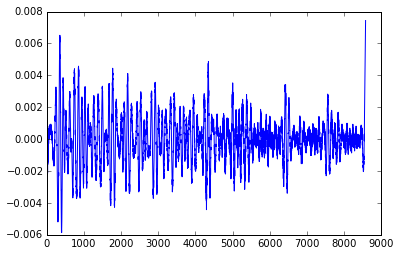

In [24]:
rsignal = rdata.mean(axis=0)
plt.plot(rsignal)

The wavelet transform of the recovered signal suggests that we have been successful:

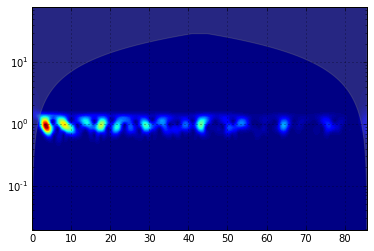

In [26]:
wavelets.WaveletTransform(rsignal, dt=0.01).plot_power()

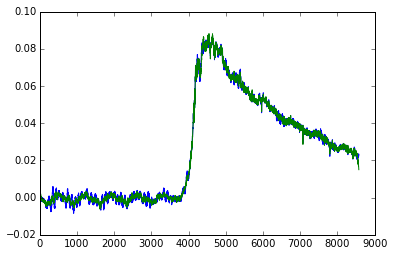

In [28]:
plt.plot(signal)
plt.plot(signal - rsignal)

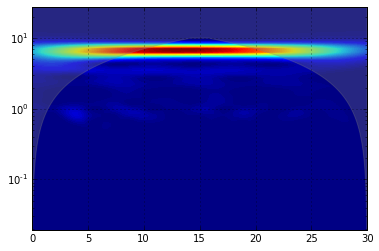

In [32]:
wavelets.WaveletTransform((signal - rsignal)[:3000], dt=0.01).plot_power()

We are left with the low frequency content that needs to be removed.

## Doug's solution

Take the average of all of the fourier transforms across all x, z and look for the anomaly signal in this.

In [33]:
all_fft = np.fft.rfft(r.U[:], axis=-1)
mean_fft = all_fft.mean(axis=0).mean(axis=0)

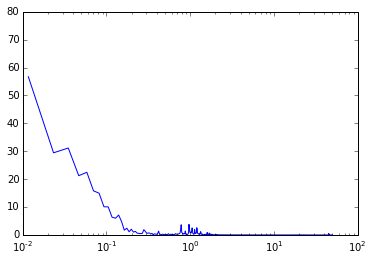

In [40]:
plt.semilogx(all_freq, np.abs(mean_fft))

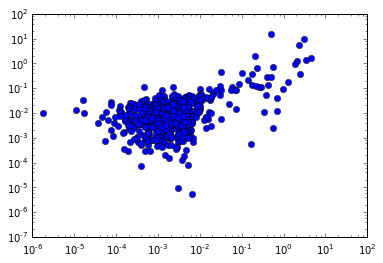

In [111]:
plt.loglog(mean_fft.real, mean_fft.imag, 'o')

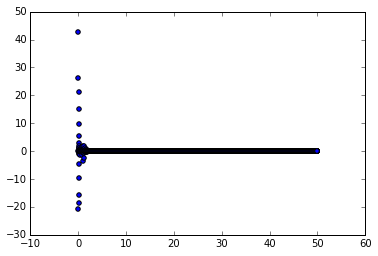

In [114]:
plt.scatter(all_freq, mean_fft.imag)

plt.angle_spectrum?

## Locko solution

Take the fourier transform peak. There probably isn't a phase change on collision with the front.

We can increase the resolution of the peak by using e.g. a cosine taper (have used kaiser before) along with zero padding the signal.

If the big wave is a standing wave in the tank then Locko can't see why there would be a phase change on reaching the current front.

If there is no phase change then we can look at the peak of the fourier transform and use this to construct the sinusoidal wave to subtract.

If there is a phase change then the problem becomes more complicated.

Another possibility is aliasing from high frequencies.

Side note: 2 pole butterworth would be better filter to use than the boxcar that I'm using now. Might not be necessary, just be mindful of a sinc function at the frequency of the boxcar edge convolved with the data.

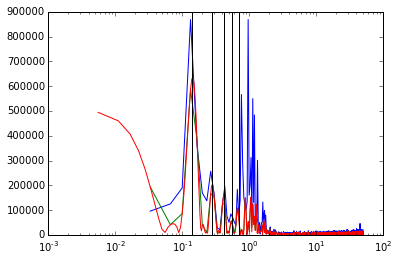

In [209]:
import scipy.signal as sig

def locko():
    presignal = (signal - rsignal)[:3000]
    
    taper = sig.cosine(presignal.size)
    taper_signal = presignal * taper

    taper_fft = np.fft.rfft(taper_signal)

    extended = np.zeros(presignal.size * 6)
    extended[:presignal.size] = presignal * taper

    extended_fft = np.fft.rfft(extended)
    extended_freqs = np.fft.rfftfreq(extended.size, d=0.01)

    plt.semilogx(freqs, np.abs(fft) / presignal.var())
    plt.semilogx(freqs, np.abs(taper_fft) / presignal.var())
    plt.semilogx(extended_freqs, np.abs(extended_fft) / presignal.var())
    
locko()

for n in range(1, 6):
    plt.axvline(n * 0.14, color='k')

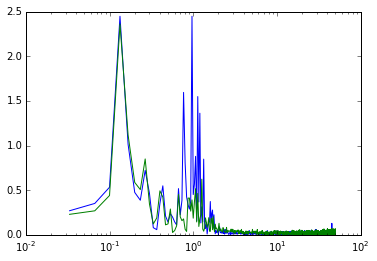

In [68]:
plt.semilogx(freqs, np.abs(np.fft.rfft(signal[:3000])))
plt.semilogx(freqs, np.abs(np.fft.rfft((signal - rsignal)[:3000])))

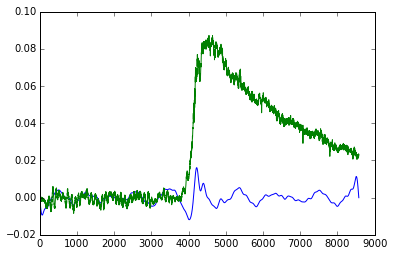

In [153]:
def remove_current(signal, cutoff, high_cutoff=False):
    fft = np.fft.rfft(signal, axis=-1)
    freqs = np.fft.rfftfreq(signal.size, d=0.01)
    
    rfft = fft.copy()
    rfft[freqs < cutoff] = 0
    
    if high_cutoff:
        rfft[freqs > high_cutoff] = 0
        
    rdata = np.fft.irfft(rfft)
    return rdata
    

plt.plot(remove_current(signal, 0.09, 0.7))
plt.plot(signal)

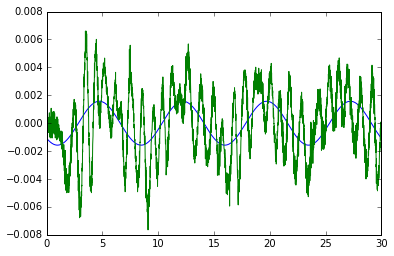

In [143]:
def reconstruct(fft, freqs, size=None):
    complex_amplitude = fft[np.abs(fft).argmax()]
    frequency = freqs[np.abs(fft).argmax()]
    
    amplitude = np.abs(complex_amplitude)
    phase = np.angle(complex_amplitude)
    
    if not size:
        size = presignal.size
    time = np.arange(size) * 0.01
    
    norm = fft.size

    rwave = (1.0 / fft.size) * amplitude * np.exp(-2j * np.pi * frequency * time) * np.exp(-1j * phase)
    
    return rwave


time = r.T[0, 0, :]
plt.plot(time[:3000] , reconstruct(np.fft.rfft((signal - rsignal)[:3000]), freqs))
plt.plot(time[:3000], presignal - presignal.mean())  # N.B. using the mean subtracted signal

(0, 30)

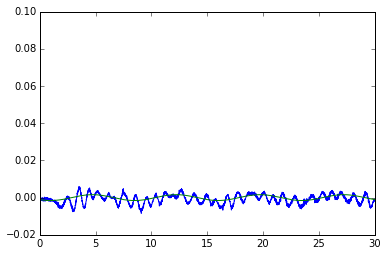

In [141]:
#plt.plot(time, remove_current(signal, 0.1, 0.7))
plt.plot(time, signal)
plt.plot(time[:3000] , reconstruct(np.fft.rfft((signal - rsignal)[:3000]), freqs))

In [144]:
rwave = reconstruct(np.fft.rfft((signal - rsignal)[:3000]), freqs, size=signal.size)

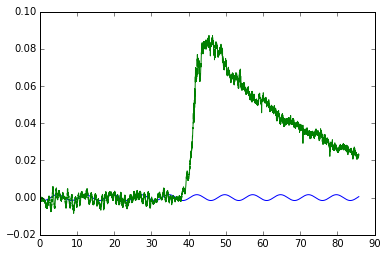

In [146]:
plt.plot(time, rwave)
plt.plot(time, signal)

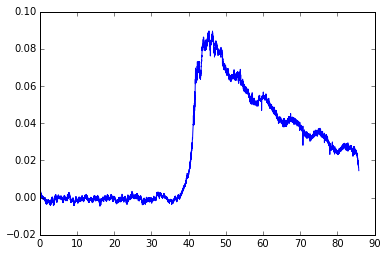

In [150]:
plt.plot(time, signal - rsignal - rwave)

This last plot suggests that there *is* a **phase change** in the large waves as they cross the front. Either that, or there are waves of the same frequency behind the front that are being masked. The latter seems unlikely.

### Demonstration of the phase change

Let us show that there is a definite phase change of the waves on crossing the front.

Another possibility is that the front breaks the vertical coherence of the waves, with there being a phase change in the gravity current interior.

<matplotlib.contour.QuadContourSet instance at 0x2ad77fbf6098>

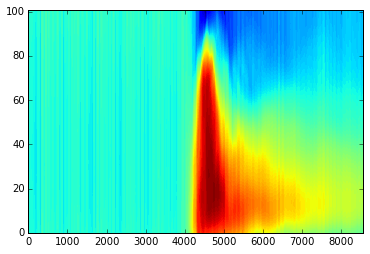

In [154]:
mean_x_signal = r.U[:].mean(axis=1)
plt.contourf(mean_x_signal, 100)

In [160]:
def remove_current_2d(signal, cutoff, high_cutoff=False):
    fft = np.fft.rfft(signal, axis=-1)
    freqs = np.fft.rfftfreq(signal.shape[-1], d=0.01)
    
    rfft = fft.copy()
    rfft[:, freqs < cutoff] = 0
    
    if high_cutoff:
        rfft[:, freqs > high_cutoff] = 0
        
    rdata = np.fft.irfft(rfft)
    return rdata

<matplotlib.contour.QuadContourSet instance at 0x2ad7bcbf3950>

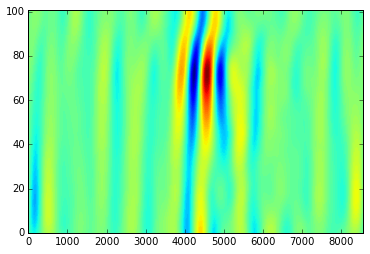

In [199]:
ss = remove_current_2d(mean_x_signal, 0.1, 0.2)
plt.contourf(ss, 100)

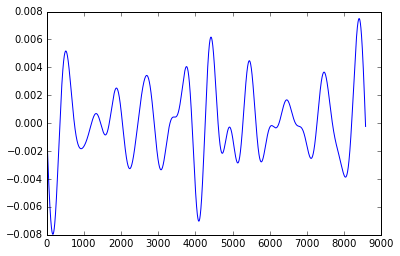

In [164]:
plt.plot(ss[20])

<matplotlib.contour.QuadContourSet instance at 0x2ad7860132d8>

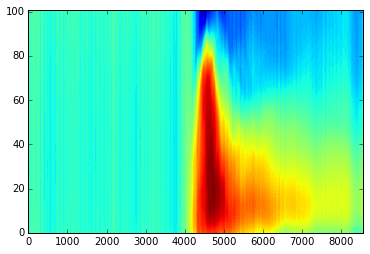

In [166]:
plt.contourf(mean_x_signal - ss[20], 100)

<matplotlib.contour.QuadContourSet instance at 0x2ad7a48f4cf8>

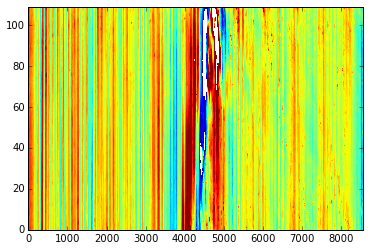

In [198]:
all_x_fft = np.fft.rfft(r.U[-1, :, :], axis=-1)
all_freq = np.fft.rfftfreq(r.U.shape[-1], d=0.01)
power = np.abs(all_x_fft)

rfft = all_x_fft.copy()
rfft[:, all_freq < 0.1] = 0 
#rfft[:, all_freq > 1] = 0 
rdata = np.fft.irfft(rfft, axis=-1)

levels = np.linspace(*np.percentile(rdata, (1, 99)))
plt.contourf(rdata, levels=levels)

<matplotlib.contour.QuadContourSet instance at 0x2ad7979abf80>

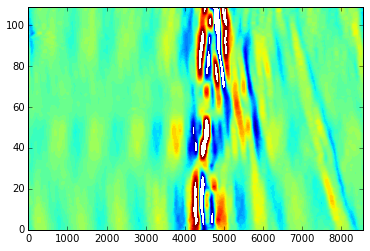

In [195]:
all_x_fft = np.fft.rfft(r.V[-10, :, :], axis=-1)
all_freq = np.fft.rfftfreq(r.U.shape[-1], d=0.01)
power = np.abs(all_x_fft)

rfft = all_x_fft.copy()
rfft[:, all_freq < 0.1] = 0
rfft[:, all_freq > 0.5] = 0 
rdata = np.fft.irfft(rfft, axis=-1)

levels = np.linspace(*np.percentile(rdata, (1, 99)))
plt.contourf(rdata, levels=levels)